#### Import dataset

In [127]:
import pandas as pd
from typing import List

selected_params = ['wai', 'nai', 'prv', 'hpv', 'xf', 'alt', 'mn', 'tat', 'n1a', 'n2a', 'ff', 'egt', 'nf']

In [128]:
fleet = ['VQ-BGU', 'VQ-BDU']

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])

data = pd.concat([bgu, bdu]) \
  .drop(columns=['file_path', 'reason']) \
  .sort_values('reportts') \
  .reset_index() \
  .drop(columns=['index'])

# data = data[data['acnum'].isin(fleet)].dropna(subset=['egtm'])

#### Generate recursive features for n previous data points

In [129]:
def get_recursive_features(data: List[pd.DataFrame], features = [], n_back = 1):
  result = []
  for df in data:
    X = df[features]
    X_aug = X.copy()
    features_back = [i + "_1" for i in features]
    X_aug.loc[0, features_back] =  X.iloc[0,:].to_numpy()
    X_aug.loc[1:, features_back] = X.iloc[:-1,:].to_numpy()
    c = ['egtm', 'reportts', 'acnum', 'pos']
    X_aug.loc[:, c] = df[c]
    result.append(X_aug)
  
  result = pd.concat(result).sort_values('reportts') \
              .reset_index() \
              .drop(columns=['index'])
  return result

data = get_recursive_features([bgu, bdu], features=selected_params)
data


,wai,nai,prv,hpv,xf,alt,mn,tat,n1a,n2a,...,tat_1,n1a_1,n2a_1,ff_1,egt_1,nf_1,egtm,reportts,acnum,pos
0,0.0,0.0,1.0,0.0,0.0,2306.0,0.269,19.0,89.32,93.96,...,-4.2,78.75,86.60,3061.0,806.7,78.71,39.054,2018-07-11 09:44:38,VQ-BDU,2
1,0.0,0.0,1.0,0.0,0.0,1968.0,0.254,25.2,84.36,92.66,...,19.0,89.32,93.96,3738.0,951.0,89.25,43.644,2018-07-11 14:11:47,VQ-BDU,2
2,0.0,0.0,1.0,0.0,0.0,2295.0,0.279,22.0,86.35,92.57,...,25.2,84.36,92.66,3205.0,908.3,84.40,41.193,2018-07-11 18:50:00,VQ-BDU,2
3,0.0,0.0,1.0,0.0,0.0,3696.0,0.276,16.0,87.15,92.64,...,22.0,86.35,92.57,3432.0,915.4,86.34,40.531,2018-07-12 01:45:02,VQ-BDU,2
4,0.0,0.0,1.0,0.0,0.0,1548.0,0.272,24.7,90.97,95.01,...,16.0,87.15,92.64,3314.0,920.6,87.11,39.994,2018-07-12 09:42:44,VQ-BDU,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3766,0.0,0.0,1.0,0.0,0.0,2487.0,0.323,-0.2,88.32,91.00,...,-15.0,83.28,86.96,3531.0,821.5,83.36,17.013,2020-02-10 17:24:01,VQ-BGU,1
3767,0.0,0.0,1.0,0.0,0.0,1845.0,0.260,-7.7,82.02,87.92,...,-0.2,88.37,91.39,3935.0,918.5,88.56,16.916,2020-02-11 02:09:38,VQ-BGU,2
3768,0.0,0.0,1.0,0.0,0.0,1845.0,0.260,-7.7,82.07,87.74,...,-0.2,88.32,91.00,3969.0,919.5,88.40,17.039,2020-02-11 02:09:38,VQ-BGU,1
3769,0.0,0.0,0.0,0.0,0.0,979.0,0.258,-4.2,78.75,86.60,...,-7.5,83.29,87.47,3318.0,826.8,83.20,15.976,2020-02-14 00:10:25,VQ-BDU,1


In [130]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error

def train_model(X, y, model = 'linreg'):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  model = Ridge(alpha=0.2)

  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)
  mse = mean_squared_error(y_train, predicted_train, squared=False)
  mae = mean_absolute_error(y_train, predicted_train)

  predicted_test = model.predict(X_test)
  mse = mean_squared_error(y_test, predicted_test, squared=False)
  mae = mean_absolute_error(y_test, predicted_test)

  return mse, mae, model, predicted_train, predicted_test, train_i, y_test

In [131]:
X = data[selected_params]
y = data['egtm']

mse, mae, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)
print(mse, mae)

4.0657345994745935 3.242534244822903


In [132]:
X = data.drop(columns=['egtm', 'acnum', 'pos', 'reportts'])
y = data['egtm']

mse, mae, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y)
print(mse, mae)

3.2300111474012403 2.580613467450849


In [133]:
# Get exponential rolling average with smothing factor alpha
def smooth(x: pd.Series, alpha=0.5):
  return pd.Series(x).ewm(alpha=alpha, adjust=False).mean().to_list()

In [146]:

avg_test = ([None] * train_i) + smooth(predicted_test, alpha=1/30)
avg_train = smooth(predicted_train, alpha=1/30) + ([None] * (len(data) - train_i)) 

data['train_pred'] = avg_train
data['test_pred'] = avg_test


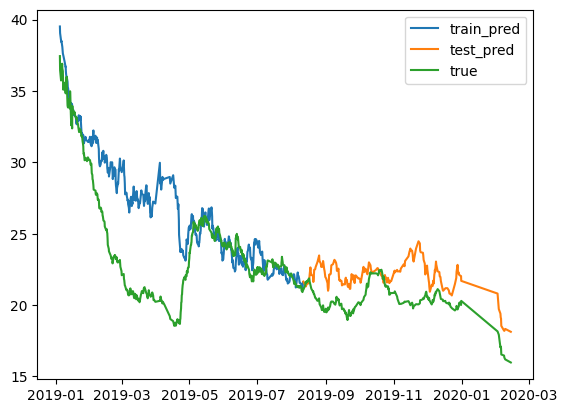

In [147]:
import matplotlib.pyplot as plt

sub = data[(data['acnum'] == 'VQ-BDU') & (data['pos'] == 1)]

plt.plot(sub['reportts'], sub['train_pred'], '-')
plt.plot(sub['reportts'], sub['test_pred'], '-')
plt.plot(sub['reportts'], sub['egtm'], '-')

plt.legend(['train_pred', 'test_pred', 'true'])
plt.show()